# Team E - Pixels plus domain knowledge to True Shower parameters with CNNs

## Team Members

* Bjarne Karsten (3559535)
* Marek Freunscht (9604914)
* Florian Hartung (6622800)

## Data and Example Download
[...]

* an exemplary jupyter notebook and futher information is available from the git repo https://github.com/astrojarred/magic-ml-images
    * You find more information there. 


## TASK 

* Improve your understanding of the data 
* The focus of this teams is the setup of MLPs or CNNs and combining them with domain knowledge like the hillas parameters
* Use the pixel information features starting "clean_image" and the features starting with "hillas" and "stereo"
    * they contain information of all the pixels for a simulated particle
        * "clean_image" contains the data after some some standard cleaning algorithms were applied. These data are used in the MAGIC analysis to derive the Hillas Parameters.
        * "hillas" and "stereo" features are derived from the raw images by using the standard MAGIC analysis workflow. 
* Create a baseline using a simple ML algorithm to
    * classify gammas and protons 
        * by combining both clean_image_\* features
        * by combining both clean_image_\* features with "hillas" and/or "stereo" 
    * predict/infer the true shower parameters using a simple ML algorithm
        * using clean_image\_\*\_m1 and clean_image\_\*\_m2 independently
        * by combining both clean_image_\* features with "hillas" and/or "stereo" 
* Use MLP and simple CNN networks following the same strategy as above to
    * classify gammas and protons 
    * predict/infer true shower parameters using a simple ML algorithm
    * Think about a method to reuse the existing CNN kernels instead of using a hexagonal approch
* compare the different approaches 




## Implementation

### Project Overview
This notebook contains a number of different models each with different parameters and input features.
To save system resources we initialize global state and read all datasets once at the start of the notebook.
From that point on our notebook is split in multiple parts, where every part can be run separately:
- Strategies: Explanations and visualizations for hexagonal images and its conversion to traditional 2d images.
- Classification models: This section contains classification-specific data preprocessing, all classification models and comparisons for all classification models.
- Regression models: This section contains regression-specific data preprocessing, all regression models and comparison for all regression models.

We designed our notebook in such a way, that one can train, save or load individual models just by settings configuration variables (see `SAVE_MODELS_AFTER_TRAINING` or `TRAIN_THIS_MODEL`).
All outputs in this model are pre-generated and this notebook also comes with pre-trained models which reside in `./trained_models`.

Most functionality is not implemented in this notebook, but rather in the `src` module.
Here is a rough outline of our module structure:
- `Team E.ipynb` **(this notebook)**
- `src/`
    - `common/`: Common python modules for this notebook and other modules
        - `__init__.py`: Common constants such as lists of feature groups, e.g. `FEATURES_HILLAS`, `FEATURES_STEREO` or `FEATURES_IMAGE_M1`.
        - `data_loading.py`: Logic for loading data from `parquet` files. We also read files in batches and flatten all images into columns of floats here.
        - `preprocessing.py`: Logic for preprocessing and splitting data into train, validation and test data.
        - `HexaToParallelogramm.py`: A torch module for converting hexagonal images to 2d images.
        - `visualizations.py`: A collection of functions for logging and plotting to achieve consistent style between models.
        - `batch.py`: TODO
    - `classification_gammas_protons/`
        - `baseline/`: A collection of baseline models for classification.
        - `mlp.py`: A model that uses a multi-layer-perceptron (MLP) for classification.
        - `cnn.py`: A model that uses CNNs for classification.
    - `infer_true_shower_parameters/`
        - `baseline/`: A collection of baseline models for inferring true shower parameters.
        - `mlp.py`: A model that uses a multi-layer-perceptron (MLP) for inferring true shower parameters.
        - `cnn.py`: A model that uses CNNs for inferring true shower parameters.

### Initialize notebook
This code does global initialization.
First it loads the `magicdl` module, which resides in `./magic-ml-images` (from <https://github.com/astrojarred/magic-ml-images>).
Then it sets global configuration variables and chooses an appropriate torch device.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import torch

# Load magicdl module
module_path = str(Path.cwd() / "magic-ml-images")
if module_path not in sys.path:
    sys.path.append(module_path)
import magicdl.magic

# The parent directory of all dataset parquet files
# Note: Currently we only `magic-protons.parquet` and `magic-gammas-new-4.parquet`
DATA_DIR = Path.cwd() / "data"

# The parent directory of where trained models are saved to and loaded from
TRAINED_MODELS_DIR = Path.cwd() / "trained_models"
TRAINED_MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Whether models trained from this notebook are saved automatically
SAVE_MODELS_AFTER_TRAINING = True

# Select torch device globally. This is later passed to all model functions
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using torch device '{torch_device}'")

# The seed used for all RNG in data preprocessing and models.
# IMPORTANT: When this seed is changed, one must not load any models trained
#            and saved with a previous different seed. Doing so would violate
#            the ML process, because the previous training/validation data
#            could now end up in the test dataset.
#
# Note: We tried to make everything reproducible and deterministic, however we were
#       not able to do so, due to a lack of understanding of torch's internals.
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

Using torch device 'cuda:0'


### Dataloading
We have defined a module for loading both proton and gamma datasets.
Our dataloading also flattens the image columns, so that every image column is converted to 1039 (number of pixels) individual float columns.
This allows to use image data more easily, as we can now index into the dataframe by specifying all image column names.

In [2]:
from src.common import *
from src.common.data_loading import load_dataset_and_flatten_images

# We choose to only load relevant images and features to save memory
FEATURES_TO_LOAD = FEATURES_HILLAS + FEATURES_STEREO + FEATURES_TRUE_SHOWER
IMAGES_TO_LOAD = ["clean_image_m1", "clean_image_m2"]

# Load the datasets
data_gammas_raw = load_dataset_and_flatten_images(
    DATA_DIR / "magic-gammas-new-4.parquet", IMAGES_TO_LOAD, FEATURES_TO_LOAD
)
data_protons_raw = load_dataset_and_flatten_images(
    DATA_DIR / "magic-protons.parquet", IMAGES_TO_LOAD, FEATURES_TO_LOAD
)

print(f"Number of loaded datapoints: gammas={len(data_gammas_raw)} protons={len(data_protons_raw)}")

Number of loaded datapoints: gammas=192795 protons=105174


### Strategies

The hexagon needs to be brought in a convolvable shape. To achieve this, we complete it to a parallelogram. This way, we can convolve along the horizontal and the diagonal.

In [3]:
lt = magicdl.magic.Geometry.lookup_table()
qs, rs = (list(t) for t in zip(*lt.keys()))

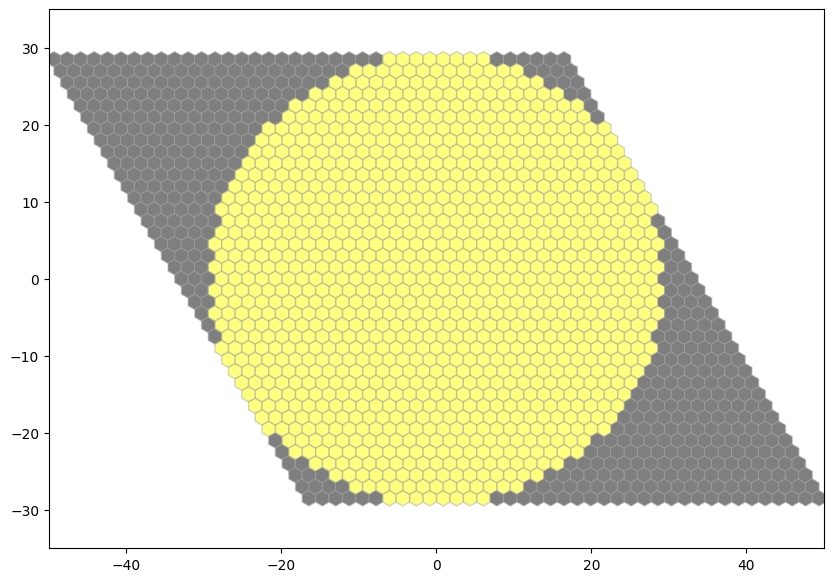

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

figsize = (10, 7)
plt.figure(figsize=figsize)
size = 1

ax = plt.gca()

for q in range(-19, 20):
    for r in range(-19,20):
        ax.add_patch(
            RegularPolygon(
                (magicdl.magic.Geometry.pointy_hex_to_pixel(q,r)),
                6,
                radius=size,
                facecolor= "yellow" if (q,r) in lt.keys() else "black",
                edgecolor="darkgray",
                alpha=0.5,
            )
        )
plt.xlim(-50, 50)
plt.ylim(-35, 35)
plt.show()

We implement a torch layer that takes tensor where the pixels are given along one dimension and passes forth a tensor where they are given two-dimensionally. The image is first filled with a given padding value. Then the given pixel values are filled in according to the logic of the magicdl module. Here q and r, the hexagonal coordinates, are reinterpreted as x and y. In the following, the padding is negative for visualisation purposes:

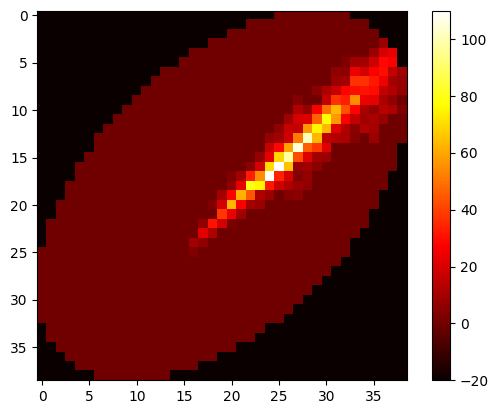

In [8]:
from src.common.HexaToParallelogram import HexaToParallelogram

p = torch.tensor(data_protons_raw[FEATURES_CLEAN_IMAGE_M1].iloc[0].tolist())

h = HexaToParallelogram(0, -20)
result = h.forward(p)

plt.imshow(result.numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

### Data preprocessing for classification models
_Note: This cell need to be run only when training, evaluating or comparing classification models. It is not required for regression models. Restarting the Jupyter Kernel might reduce system resource usage when switching between classification and regression models._

This does preprocessing specific to classification. That includes adding class labels, concatenating both class datasets and normalizing parameters across both combined datasets.

In [3]:
from src.common.preprocessing import preprocess
import pandas as pd

# Assign binary class labels
data_gammas_raw["class"] = 0.0
data_protons_raw["class"] = 1.0

# This constant is used to make up for imbalanced training data in each model's loss function
pos_weight = len(data_gammas_raw) / len(data_protons_raw)

# Concat both datasets. There is not need to shuffle, as that will be done by torch's dataloaders automatically
data_classification = pd.concat([data_gammas_raw, data_protons_raw])

# We got the best results when normalizing all features
normalize_params = (
    FEATURES_HILLAS
    + FEATURES_STEREO
    + FEATURES_TRUE_SHOWER
    + FEATURES_CLEAN_IMAGE_M1
    + FEATURES_CLEAN_IMAGE_M2
)

data_classification_train, data_classification_validation, data_classification_test = (
    preprocess(
        data_classification,
        normalize_params=normalize_params,
        stratify_column_name="class",
        train_portion=0.7,
        validation_portion=0.2,
        seed=SEED,
    )
)

### Model: Classification with MLP
This model uses a fully-connected neural network to classify protons and gamma particles.
It concatenates both cleaned images (`clean_image_m1` & `clean_image_m2`) and feeds those into the input layer. This input layer leads into two hidden layers which result into a singular scalar output layer.

This model uses rectified linear units (ReLU) as activation functions between all layers.

To prevent overfitting, a combination of Dropout and Batch Normalization is used before the hidden layers. From experimenting with different values, a dropout rate of 0.1 or 0.2 has yielded the best results.

The final layer does not use a sigmoid function itself, as this is not recommended for binary classification (https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

Epoch 1/2 (took 11.9s) - TRAIN(loss|acc): 0.84|61.95% - VALID(loss|acc): 0.66|62.08%
Epoch 2/2 (took 12.1s) - TRAIN(loss|acc): 0.80|65.21% - VALID(loss|acc): 0.59|67.40%


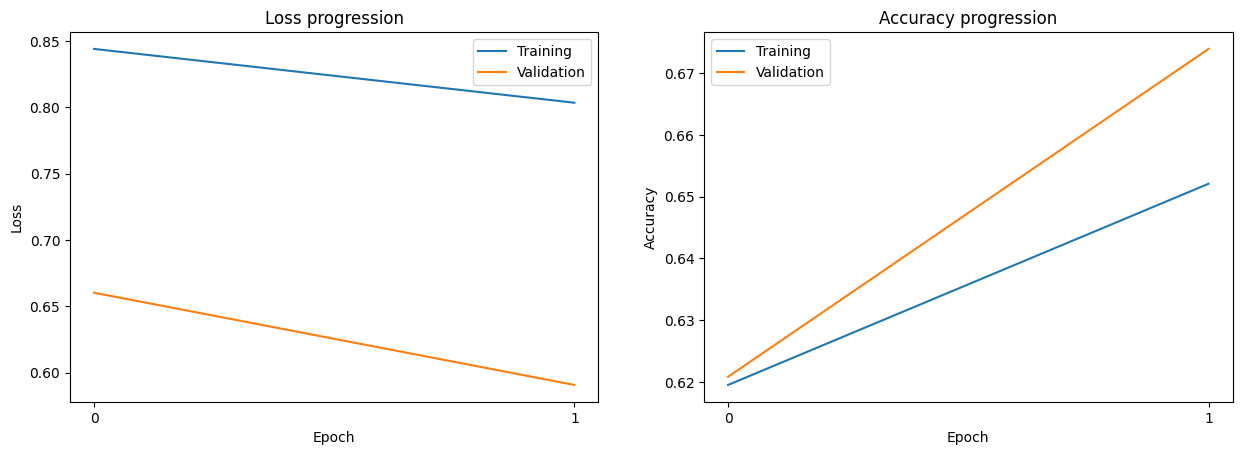

In [5]:
import src.classification_gammas_protons.mlp as classification_mlp

TRAIN_THIS_MODEL = True
THIS_MODEL_NAME = "classification_mlp"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2

model = None
if TRAIN_THIS_MODEL:
    model = classification_mlp.train(
        data_classification_train,
        data_classification_validation,
        features=features,
        class_feature="class",
        pos_weight=pos_weight,
        device=torch_device,
        epochs=2,
    )

    if SAVE_MODELS_AFTER_TRAINING:
        classification_mlp.save(model, trained_model_path)
else:
    model = classification_mlp.load(trained_model_path, len(features))

Epoch 1/2 (took 12.7s) - TRAIN(loss|acc): 0.64|75.66% - VALID(loss|acc): 0.42|81.03%
Epoch 2/2 (took 11.6s) - TRAIN(loss|acc): 0.55|79.90% - VALID(loss|acc): 0.40|81.82%


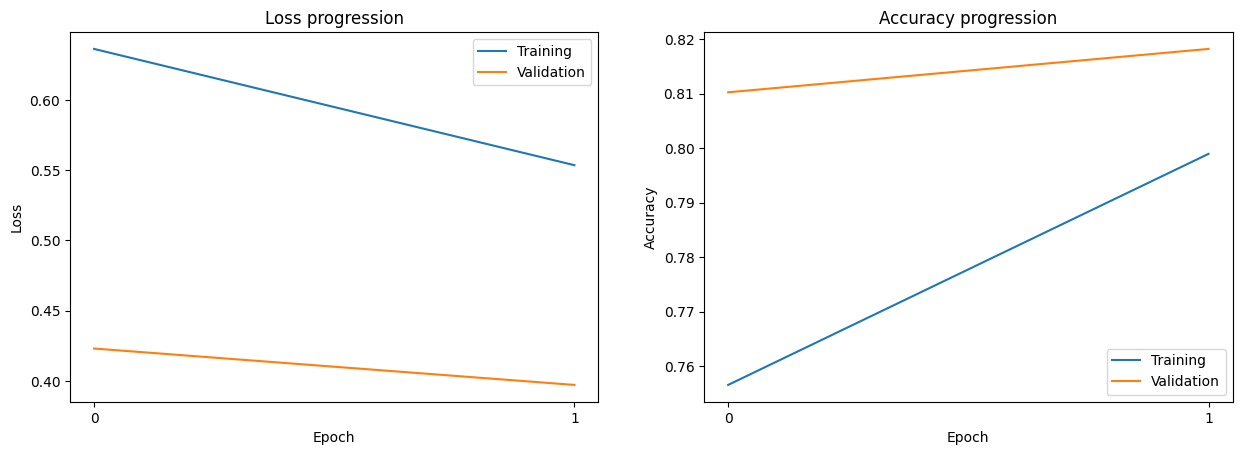

In [6]:
import src.classification_gammas_protons.mlp as classification_mlp

TRAIN_THIS_MODEL = True
THIS_MODEL_NAME = "classification_mlp_with_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS

model = None
if TRAIN_THIS_MODEL:
    model = classification_mlp.train(
        data_classification_train,
        data_classification_validation,
        features=features,
        class_feature="class",
        pos_weight=pos_weight,
        device=torch_device,
        epochs=2,
    )

    if SAVE_MODELS_AFTER_TRAINING:
        classification_mlp.save(model, trained_model_path)
else:
    model = classification_mlp.load(trained_model_path, len(features))

Epoch 1/2 (took 13.0s) - TRAIN(loss|acc): 0.72|74.82% - VALID(loss|acc): 0.54|76.61%
Epoch 2/2 (took 12.7s) - TRAIN(loss|acc): 0.67|77.06% - VALID(loss|acc): 0.52|75.56%


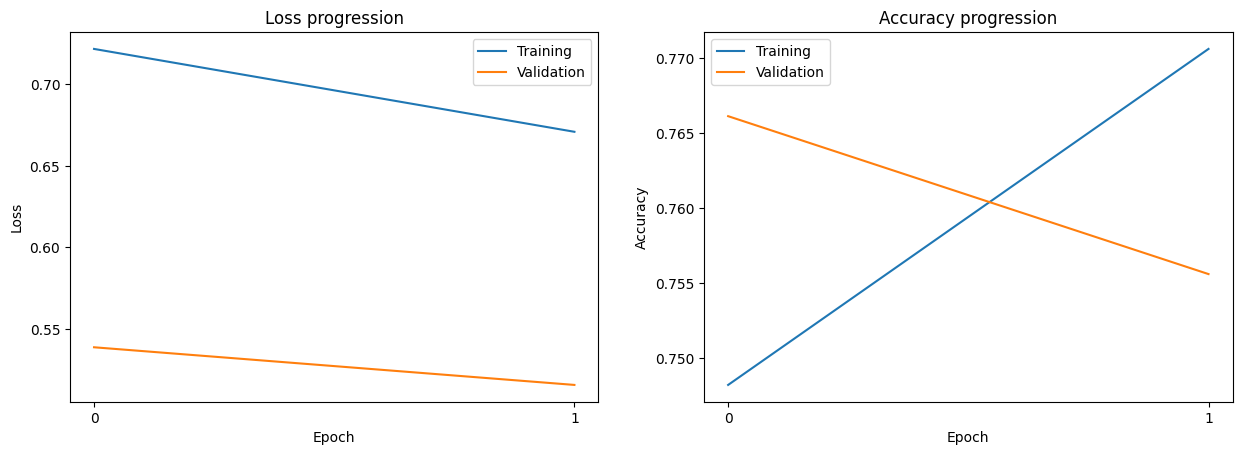

In [7]:
import src.classification_gammas_protons.mlp as classification_mlp

TRAIN_THIS_MODEL = True
THIS_MODEL_NAME = "classification_mlp_with_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_STEREO

model = None
if TRAIN_THIS_MODEL:
    model = classification_mlp.train(
        data_classification_train,
        data_classification_validation,
        features=features,
        class_feature="class",
        pos_weight=pos_weight,
        device=torch_device,
        epochs=2,
    )

    if SAVE_MODELS_AFTER_TRAINING:
        classification_mlp.save(model, trained_model_path)
else:
    model = classification_mlp.load(trained_model_path, len(features))

Epoch 1/20 (took 11.9s) - TRAIN(loss|acc): 0.55|82.23% - VALID(loss|acc): 0.35|86.47%
Epoch 2/20 (took 11.8s) - TRAIN(loss|acc): 0.47|85.93% - VALID(loss|acc): 0.33|87.14%
Epoch 3/20 (took 12.1s) - TRAIN(loss|acc): 0.45|86.79% - VALID(loss|acc): 0.31|88.08%
Epoch 4/20 (took 11.8s) - TRAIN(loss|acc): 0.43|87.12% - VALID(loss|acc): 0.32|87.90%
Epoch 5/20 (took 11.8s) - TRAIN(loss|acc): 0.42|87.44% - VALID(loss|acc): 0.31|87.79%
Epoch 6/20 (took 12.3s) - TRAIN(loss|acc): 0.41|87.60% - VALID(loss|acc): 0.31|87.99%
Epoch 7/20 (took 12.0s) - TRAIN(loss|acc): 0.40|87.95% - VALID(loss|acc): 0.31|88.01%
Epoch 8/20 (took 12.5s) - TRAIN(loss|acc): 0.40|88.13% - VALID(loss|acc): 0.32|87.26%
Epoch 9/20 (took 12.5s) - TRAIN(loss|acc): 0.39|88.29% - VALID(loss|acc): 0.34|86.35%
Epoch 10/20 (took 12.6s) - TRAIN(loss|acc): 0.38|88.41% - VALID(loss|acc): 0.31|87.59%
Epoch 11/20 (took 12.4s) - TRAIN(loss|acc): 0.38|88.53% - VALID(loss|acc): 0.34|86.19%
Epoch 12/20 (took 13.1s) - TRAIN(loss|acc): 0.38|88.

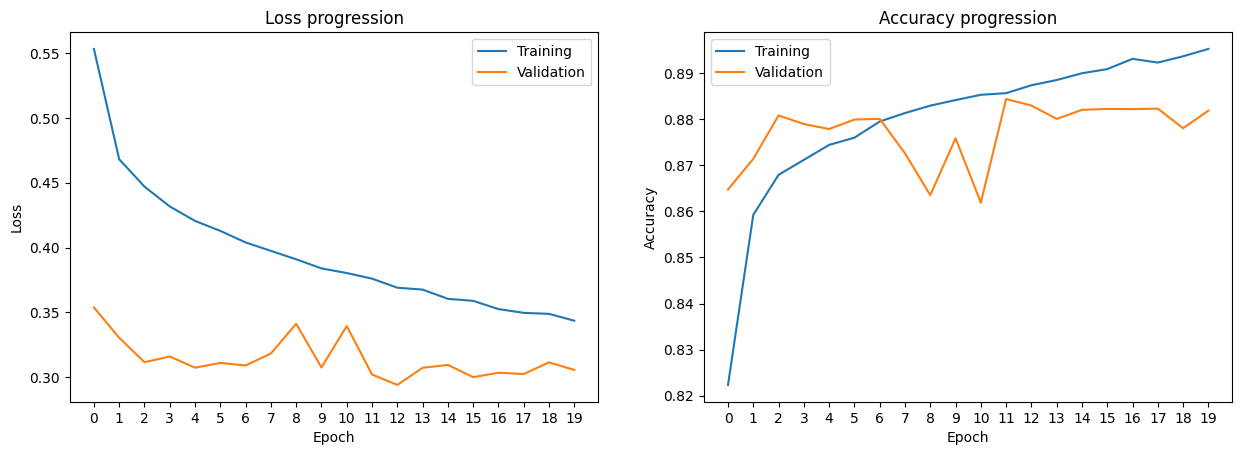

In [9]:
import src.classification_gammas_protons.mlp as classification_mlp

TRAIN_THIS_MODEL = True
THIS_MODEL_NAME = "classification_mlp_with_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")
features = FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS + FEATURES_STEREO

model = None
if TRAIN_THIS_MODEL:
    model = classification_mlp.train(
        data_classification_train,
        data_classification_validation,
        features=features,
        class_feature="class",
        pos_weight=pos_weight,
        device=torch_device,
        epochs=20,
    )

    if SAVE_MODELS_AFTER_TRAINING:
        classification_mlp.save(model, trained_model_path)
else:
    model = classification_mlp.load(trained_model_path, len(features))

### Model: Classification with CNN
This model uses a CNN combined with a fully-connected neural network to classify protons and gamma particles.

It feeds both cleaned images (`clean_image_m1` & `clean_image_m2`) into a CNN with two convolutional, two ReLU and two max-pooling layers.

Then the CNN's outputs are passed to a fully-connected neural network.
For 3 of the 4 variants of this model we also concatenate the CNN's output and some additional features such as the hillas, stereo or hillas + stereo parameters.
We do this, because those additional features have not spacial relations between each other and thus passing them through a CNN would not make sense.

The fully-connected neural network (FCNN) consists of 3 layers and two ReLU activations after the first 2 layers.
Similar to the MLP this FCNN also uses no activation function in its last layer, because using one is not recommended for our binary classification loss function [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

Epoch 1/5 (took 43.0s) - TRAIN(loss|acc): 0.65|73.15% - VALID(loss|acc): 0.39|82.46%
Epoch 2/5 (took 41.8s) - TRAIN(loss|acc): 0.50|82.30% - VALID(loss|acc): 0.35|84.49%
Epoch 3/5 (took 42.8s) - TRAIN(loss|acc): 0.47|83.77% - VALID(loss|acc): 0.35|84.03%
Epoch 4/5 (took 42.0s) - TRAIN(loss|acc): 0.46|84.58% - VALID(loss|acc): 0.35|84.94%
Epoch 5/5 (took 40.9s) - TRAIN(loss|acc): 0.44|85.17% - VALID(loss|acc): 0.35|84.18%
Test data evaluation - LOSS: 0.35 - ACC: 84.626%


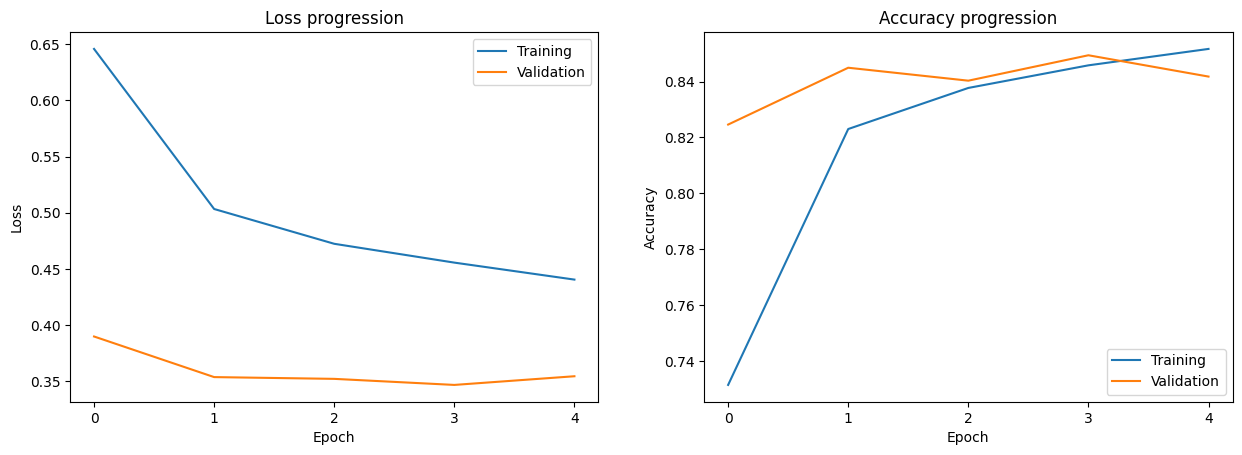

In [7]:
import src.classification_gammas_protons.cnn as classification_cnn
from src.common.visualizations import print_test_results

TRAIN_THIS_MODEL = True
THIS_MODEL_NAME = "classification_cnn"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = None
if TRAIN_THIS_MODEL:
    model = classification_cnn.train(
        data_classification_train,
        data_classification_validation,
        image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
        additional_features=[],
        class_feature="class",
        device=torch_device,
        pos_weight=pos_weight,
        epochs=5,
    )

    if SAVE_MODELS_AFTER_TRAINING:
        classification_cnn.save(model, trained_model_path)
else:
    model = classification_cnn.load(trained_model_path, additional_features=[])

Epoch 1/5 (took 41.5s) - TRAIN(loss|acc): 0.51|81.52% - VALID(loss|acc): 0.35|83.61%
Epoch 2/5 (took 38.4s) - TRAIN(loss|acc): 0.43|85.19% - VALID(loss|acc): 0.33|85.39%
Epoch 3/5 (took 38.4s) - TRAIN(loss|acc): 0.40|86.63% - VALID(loss|acc): 0.30|87.07%
Epoch 4/5 (took 41.1s) - TRAIN(loss|acc): 0.38|87.36% - VALID(loss|acc): 0.29|88.04%
Epoch 5/5 (took 39.8s) - TRAIN(loss|acc): 0.37|87.84% - VALID(loss|acc): 0.29|87.76%
Test data evaluation - LOSS: 0.29 - ACC: 87.659%


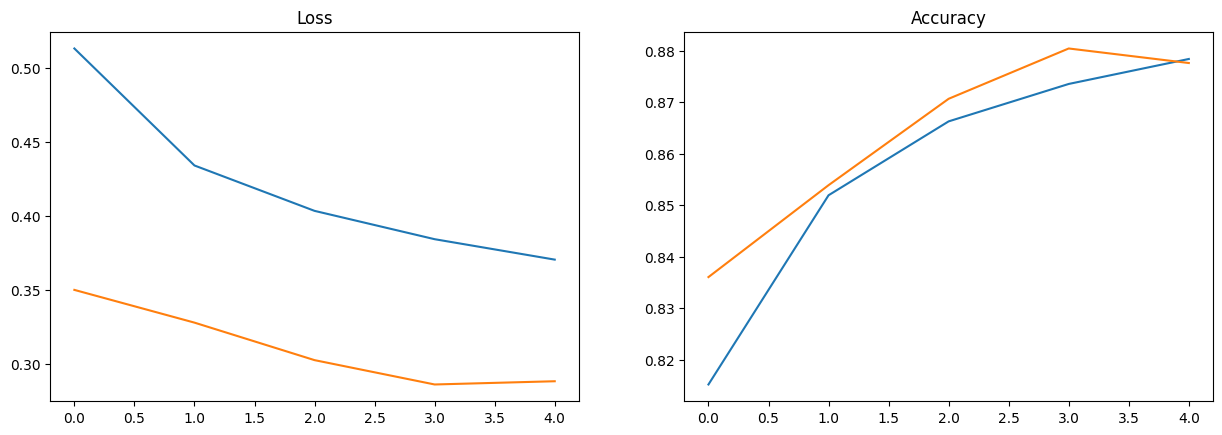

In [4]:
import src.classification_gammas_protons.cnn as classification_cnn
from src.common.visualizations import print_test_results

TRAIN_THIS_MODEL = True
THIS_MODEL_NAME = "classification_cnn_with_hillas"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = None
if TRAIN_THIS_MODEL:
    model = classification_cnn.train(
        data_classification_train,
        data_classification_validation,
        image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
        additional_features=FEATURES_HILLAS,
        class_feature="class",
        device=torch_device,
        pos_weight=pos_weight,
        epochs=5,
    )

    if SAVE_MODELS_AFTER_TRAINING:
        classification_cnn.save(model, trained_model_path)
else:
    model = classification_cnn.load(trained_model_path, additional_features=FEATURES_HILLAS)

# Evaluate model on test data
test_results = classification_cnn.evaluate(
    model,
    data_classification_test,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS,
    class_feature="class",
    device=torch_device,
)
print_test_results(*test_results)


Epoch 1/5 (took 40.1s) - TRAIN(loss|acc): 0.57|79.79% - VALID(loss|acc): 0.37|84.18%
Epoch 2/5 (took 40.4s) - TRAIN(loss|acc): 0.44|85.85% - VALID(loss|acc): 0.32|86.62%
Epoch 3/5 (took 40.9s) - TRAIN(loss|acc): 0.40|87.26% - VALID(loss|acc): 0.31|87.74%
Epoch 4/5 (took 40.6s) - TRAIN(loss|acc): 0.39|88.01% - VALID(loss|acc): 0.33|86.10%
Epoch 5/5 (took 41.0s) - TRAIN(loss|acc): 0.37|88.44% - VALID(loss|acc): 0.33|86.22%
Test data evaluation - LOSS: 0.33 - ACC: 86.073%


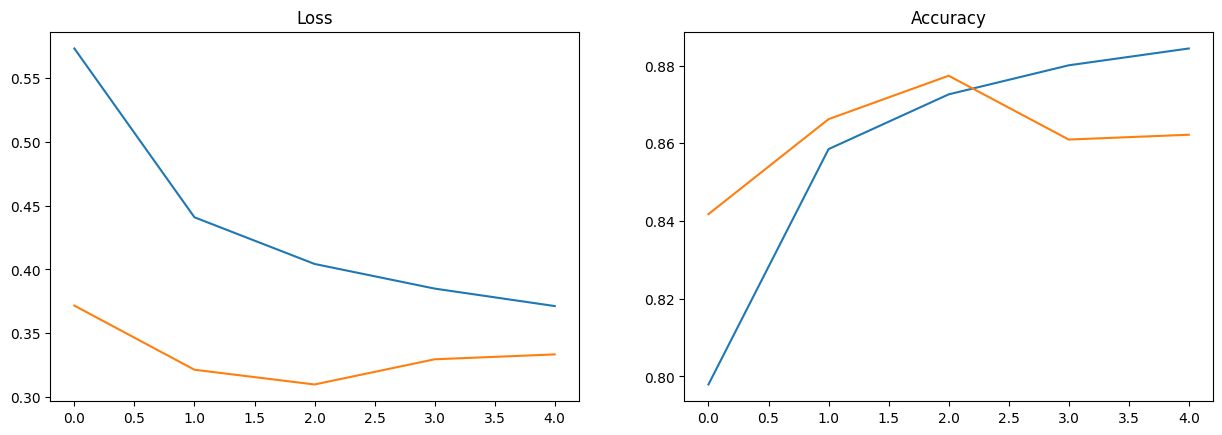

In [5]:
import src.classification_gammas_protons.cnn as classification_cnn
from src.common.visualizations import print_test_results

TRAIN_THIS_MODEL = True
THIS_MODEL_NAME = "classification_cnn_with_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = None
if TRAIN_THIS_MODEL:
    model = classification_cnn.train(
        data_classification_train,
        data_classification_validation,
        image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
        additional_features=FEATURES_STEREO,
        class_feature="class",
        device=torch_device,
        pos_weight=pos_weight,
        epochs=5,
    )

    if SAVE_MODELS_AFTER_TRAINING:
        classification_cnn.save(model, trained_model_path)
else:
    model = classification_cnn.load(trained_model_path, additional_features=FEATURES_STEREO)


Epoch 1/20 (took 41.2s) - TRAIN(loss|acc): 0.44|86.20% - VALID(loss|acc): 0.29|88.32%
Epoch 2/20 (took 40.8s) - TRAIN(loss|acc): 0.37|88.36% - VALID(loss|acc): 0.28|88.58%
Epoch 3/20 (took 40.3s) - TRAIN(loss|acc): 0.35|89.13% - VALID(loss|acc): 0.27|89.16%
Epoch 4/20 (took 40.4s) - TRAIN(loss|acc): 0.33|89.69% - VALID(loss|acc): 0.28|88.34%
Epoch 5/20 (took 41.3s) - TRAIN(loss|acc): 0.32|90.20% - VALID(loss|acc): 0.27|88.83%
Epoch 6/20 (took 41.2s) - TRAIN(loss|acc): 0.31|90.44% - VALID(loss|acc): 0.24|90.46%
Epoch 7/20 (took 41.1s) - TRAIN(loss|acc): 0.30|90.72% - VALID(loss|acc): 0.24|90.29%
Epoch 8/20 (took 41.8s) - TRAIN(loss|acc): 0.29|91.02% - VALID(loss|acc): 0.25|89.76%
Epoch 9/20 (took 40.9s) - TRAIN(loss|acc): 0.28|91.28% - VALID(loss|acc): 0.24|90.41%
Epoch 10/20 (took 41.2s) - TRAIN(loss|acc): 0.27|91.47% - VALID(loss|acc): 0.26|89.25%
Epoch 11/20 (took 40.9s) - TRAIN(loss|acc): 0.26|91.61% - VALID(loss|acc): 0.24|90.35%
Epoch 12/20 (took 41.5s) - TRAIN(loss|acc): 0.26|91.

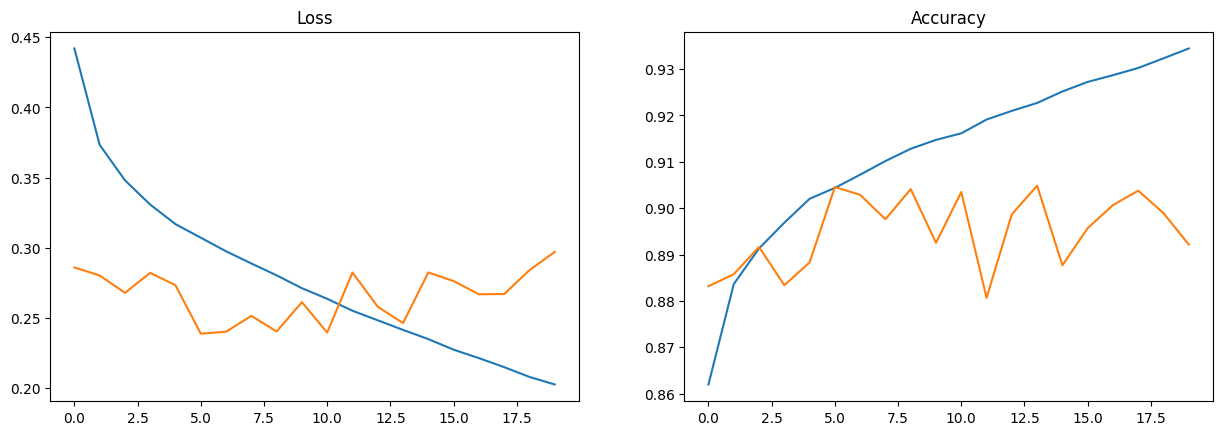

In [5]:
import src.classification_gammas_protons.cnn as classification_cnn
from src.common.visualizations import print_test_results

TRAIN_THIS_MODEL = True
THIS_MODEL_NAME = "classification_cnn_with_hillas_stereo"

trained_model_path = TRAINED_MODELS_DIR / (THIS_MODEL_NAME + ".pth")

model = None
if TRAIN_THIS_MODEL:
    model = classification_cnn.train(
        data_classification_train,
        data_classification_validation,
        image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
        additional_features=FEATURES_HILLAS + FEATURES_STEREO,
        class_feature="class",
        device=torch_device,
        pos_weight=pos_weight,
        epochs=20,
    )

    if SAVE_MODELS_AFTER_TRAINING:
        classification_cnn.save(model, trained_model_path)
else:
    model = classification_cnn.load(trained_model_path, FEATURES_HILLAS + FEATURES_STEREO, torch_device)

# Evaluate model on test data
test_results = classification_cnn.evaluate(
    model,
    data_classification_test,
    image_features=[FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
    additional_features=FEATURES_HILLAS + FEATURES_STEREO,
    class_feature="class",
    device=torch_device,
)
all_test_results[THIS_MODEL_NAME] = test_results
print_test_results(*test_results)

### Comparison of classification models
This section loads all classification models and evaluates them on the test dataset.
All accuracies are output for each model and different variations of input features (none, hillas, stereo, hillas + stereo).

Note: These accuracies are not to be used to optimize models, as this would respect the ML process.

In [17]:
from src.classification_gammas_protons import (
    cnn as classification_cnn,
    mlp as classification_mlp,
)
import numpy as np
from typing import Optional, Tuple


def evaluate_classification_mlp_model(
    model_name: str, features: list[str]
) -> float | str:
    path = TRAINED_MODELS_DIR / f"{model_name}.pth"
    if not path.exists():
        return str(path)

    model = classification_mlp.load(path, len(features), torch_device)

    _loss, accuracy = classification_mlp.evaluate(
        model,
        torch_device,
        classification_mlp.create_dataset(
            data_classification_test, features, "class", torch_device
        ),
    )

    return accuracy


def evaluate_classification_cnn_model(
    model_name: str, additional_features: list[str]
) -> float | str:
    path = TRAINED_MODELS_DIR / f"{model_name}.pth"
    if not path.exists():
        return str(path)

    model = classification_cnn.load(path, additional_features, torch_device)

    _loss, accuracy = classification_cnn.evaluate(
        model,
        data_classification_test,
        [FEATURES_CLEAN_IMAGE_M1, FEATURES_CLEAN_IMAGE_M2],
        additional_features,
        "class",
        torch_device,
    )

    return accuracy


results = [
    evaluate_classification_mlp_model(
        "classification_mlp",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2,
    ),
    evaluate_classification_mlp_model(
        "classification_mlp_with_hillas",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_HILLAS,
    ),
    evaluate_classification_mlp_model(
        "classification_mlp_with_stereo",
        FEATURES_CLEAN_IMAGE_M1 + FEATURES_CLEAN_IMAGE_M2 + FEATURES_STEREO,
    ),
    evaluate_classification_mlp_model(
        "classification_mlp_with_hillas_stereo",
        FEATURES_CLEAN_IMAGE_M1
        + FEATURES_CLEAN_IMAGE_M2
        + FEATURES_HILLAS
        + FEATURES_STEREO,
    ),
    evaluate_classification_cnn_model("classification_cnn", []),
    evaluate_classification_cnn_model(
        "classification_cnn_with_hillas",
        FEATURES_HILLAS,
    ),
    evaluate_classification_cnn_model(
        "classification_cnn_with_stereo",
        FEATURES_STEREO,
    ),
    evaluate_classification_cnn_model(
        "classification_cnn_with_hillas_stereo",
        FEATURES_HILLAS + FEATURES_STEREO,
    ),
]

result_accuracies = []
models_not_found = []
for result in results:
    if isinstance(result, str):
        models_not_found.append(result)
        result_accuracies.append("")
    else:
        result_accuracies.append(f"{100 * result:.2f}")

if len(models_not_found) > 0:
    print(f"Warning: Failed to load models {models_not_found}")

table = pd.DataFrame(
    np.array(result_accuracies).reshape([4, 2]),
    [
        "Cleaned images",
        "Cleaned images + Hillas",
        "Cleaned images + Stereo",
        "Cleaned images + Hillas + Stereo",
    ],
    ["MLP", "CNN"],
)
table.style.set_caption("Accuracy in %")

,MLP,CNN
Cleaned images,55.64,34.84
Cleaned images + Hillas,34.89,64.91
Cleaned images + Stereo,85.32,87.66
Cleaned images + Hillas + Stereo,86.07,89.08


### Data preprocessing for regression models
_Note: This cell need to be run only when training, evaluating or comparing regression models. It is not required for classification models. Restarting the Jupyter Kernel might reduce system resource usage when switching between classification and regression models._

This does preprocessing specific to regression such as normalizing features for each class dataset individually.

In [ ]:
from src.common.preprocessing import preprocess
import pandas as pd

normalize_params = (
    PARAMS_HILLAS
    + PARAMS_STEREO
    + PARAMS_TRUE_SHOWER
    + PARAMS_CLEAN_IMAGE_M1
    + PARAMS_CLEAN_IMAGE_M2
)

(
    data_regression_gammas_train,
    data_regression_gammas_validation,
    data_regression_gammas_test,
) = preprocess(
    data_gammas_raw,
    normalize_params=normalize_params,
    train_portion=0.7,
    validation_portion=0.2,
    seed=SEED,
)

(
    data_regression_protons_train,
    data_regression_protons_validation,
    data_regression_protons_test,
) = preprocess(
    data_protons_raw,
    normalize_params=normalize_params,
    train_portion=0.7,
    validation_portion=0.2,
    seed=SEED,
)

# Conclusion
- What did we try